# 6. Add Observations and Remove Unnecessary Features

**RECAP:** From **5. Logistic Regression (1)** the contribution of each feature was assessed through a logistic regression model on the training data.

This information will be used in this section to remove the most *unimportant* features and add new features from the *observations* table that was initially not included in the analysis

## Prep

### Import modules

In [87]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

---

## Read & Consolidate *observations* Tables

The *observations* tables obtained from Synthea was not consolidated into a single table within the SQL database *prediabetes* from whence all other tables were extracted. This is partly due to computational limitations considerations.  
The *observations* tables from all 12 *output directories* will now be directly read into pandas dataframes, cleaned up, consolidated into a single dataframe and rearranged to a format suitable for statistical and machine learning analyses.

### Read and consolidate observations into a single table

***NB!*** **`path`** will have to be **MODIFIED** below.

In [ ]:
# Read and merge all csv tables for observations:
for i in range (1, 13):
    
    ####################################
    # MAKE SURE TO MODIFY PATH TO FILE #
    ####################################
    
    # Declare path to table:
    path = '/home/vassil/Documents/BrainStation_Capston/synthea_1m_fhir_3_0_May_24/output_'+str(i)+'/observations.csv'
    
    print (f'Reading table {i} ...')
    
    if i == 1: # reading first table
        observations = pd.read_csv (path)
        
        # Drop unnecessary columns
        observations.drop (['ENCOUNTER', 'CODE'],
                           axis = 1,
                           inplace = True
                          )
        
    else: # reading subsequent tables
        a = pd.read_csv (path)
        
        # Drop unnecessary columns
        a.drop(['ENCOUNTER', 'CODE'],
                axis = 1,
                inplace = True
              )
        
        print (f'Appending table numer {i}...')
        
        # merge with existin observations table:
        observations = observations.append (
            a, ignore_index = True
        )
        
        # Clean up memory
        del a
        
    print (f'Table number {i} appended!')
    print (f'Total table size is {observations.shape[0]}.\n ------------------------')

In [ ]:
# Save observations to a csv file:
observations.to_csv ('observations.csv')

### Tidy `observations` table

In [2]:
filepath_observations = r'C:\Users\Public\Documents\Vassil\observations.csv'

# Read observations data:
observations = pd.read_csv (filepath_observations)
# drop unnamed column
observations.drop(observations.columns[0], axis = 1, inplace = True)
print(observations.shape)

Our table contains over 60 million records for various observations/measurements/tests for many patients. What we want is to obtain a table showing all observation values for each patient.

### Transform `observations` table

In [4]:
observations.describe()

,DATE,PATIENT,DESCRIPTION,VALUE,UNITS
count,60319963,60319963,60319963,60161459,60161459
unique,23756,1325027,63,20196,17
top,2017-03-28,16f61d26-db5e-4843-8552-f6ddfc0fcfde,Body Height,1.0,mg/dL
freq,25725,296,6563351,1780141,13254828


In [5]:
# Obtain total number NaNs for the table
print(observations.isna().sum())

DATE                0
PATIENT             0
DESCRIPTION         0
VALUE          158504
UNITS          158504
dtype: int64


Let us see which descriptions are associated with NaN for values and for units

In [10]:
# Subset data for observations lacking values
observations_na = observations[ observations['VALUE'].isna() | observations['UNITS'].isna()]
# display categories lacking values:
diagnosis_categories = list ( set (observations_na['DESCRIPTION']))
print (diagnosis_categories)

['Cardiac Arrest', 'Pulmonary emphysema (disorder)', 'Myocardial Infarction', 'End stage renal disease', 'Pneumonia', 'Chronic obstructive bronchitis (disorder)', "Alzheimer's disease (disorder)", 'Non-small cell lung cancer (disorder)', "Familial Alzheimer's disease of early onset (disorder)", 'Drug overdose', 'Stroke', 'Small cell carcinoma of lung (disorder)']


We can infer that the observations above are actually diagnoses and can therefore not be measured. In this context, the `VALUE` will be set to 1 in our `observations` table indicating the patient was diagnosed with the disease or 0 otherwise (we do not expect to have any 0's at this stage). We will not worry about the `UNITS` yet.

In [11]:
# Set NaN VALUE to 1:
observations['VALUE'].fillna(1, inplace = True)
# Check again:
print(observations.isna().sum())

DATE                0
PATIENT             0
DESCRIPTION         0
VALUE               0
UNITS          158504
dtype: int64


No more NaN values.

Make sure all the units are the same for each type of observations so they can be removed entirely.

In [12]:
# Get unique values for each category
unique_units = observations.groupby('DESCRIPTION')['UNITS'].unique()
unique_units = unique_units.to_frame()

We can see that there are a total of 63 types of observations. We will now examine the table more closely in order to determine whether the UNITS column should be kept - i.e. whether different units are used for measuring the same observations.

In [13]:
chunk = int(unique_units.shape[0]/3)
for i in range (0, unique_units.shape[0]+1, chunk):
    print (i, '\n')
    print (unique_units[i : i+chunk])

0 

                                                          UNITS
DESCRIPTION                                                    
Abuse Status [OMAHA]                                [{nominal}]
Alzheimer's disease (disorder)                            [nan]
American house dust mite IgE Ab in Serum                 [kU/L]
Are you covered by health insurance or some oth...  [{nominal}]
Body Height                                                [cm]
Body Mass Index                                         [kg/m2]
Body Weight                                                [kg]
Calcium                                                 [mg/dL]
Carbon Dioxide                                         [mmol/L]
Cardiac Arrest                                            [nan]
Cat dander IgE Ab in Serum                               [kU/L]
Chloride                                               [mmol/L]
Chronic obstructive bronchitis (disorder)                 [nan]
Cladosporium herbarum IgE Ab in Seru

It is clear that a single measurement unit is used per observation type. We can therefore safely ignore the *UNITS* column of the `observations` table.  
Note that some units are *nan*. These correspond to the diagnoses from above that cannot be quantified using specific units.

In [14]:
observations.drop('UNITS', axis = 1, inplace = True)

Now, we will pivot the observations table so that each patient (rows) is associated with specific observations (columns) and the values for the appripriate observations will fill the table. Only the last observation will be kept based on observation `DATE`.

In [15]:
# Convert DATE to type datetime and sort

# Check the format of the 'DATE' column
if not pd.api.types.is_datetime64_any_dtype(observations['DATE']):
    # Convert 'DATE' column to datetime format
    observations['DATE'] = pd.to_datetime(observations['DATE'])

# Sort in descending order for DATE
observations.sort_values('DATE', ascending=False, inplace = True)

# Drop duplicated rows:
observations = observations.drop_duplicates()
print(observations.shape)

(58530274, 4)


The `observations` table was reduced to a bit over 58 million relevant entries.

In [16]:
# Keep only the most recent observation per patient:
# Group by 'PATIENT' and 'DESCRIPTION', select the first row for each group
observations = observations.groupby(['PATIENT', 'DESCRIPTION']).first().reset_index()
print(observations.shape)

display(observations.head(5))

(14261466, 4)


,PATIENT,DESCRIPTION,DATE,VALUE
0,00000579-4471-4e83-9084-6234196c2ba5,Body Height,2016-10-15,159.77
1,00000579-4471-4e83-9084-6234196c2ba5,Body Mass Index,2016-10-15,34.4
2,00000579-4471-4e83-9084-6234196c2ba5,Body Weight,2016-10-15,87.82
3,00000579-4471-4e83-9084-6234196c2ba5,Calcium,2016-10-15,9.94
4,00000579-4471-4e83-9084-6234196c2ba5,Carbon Dioxide,2016-10-15,28.0


By keeping only the last diagnosis/observation for each patient, the data was further reduced to a little over 14 million entries. Note that keeping only the last observation is a rather primitive way to include the medical observations in our modeling. This feature engineering can be expanded in the future by assessing impact on model performance of the following transformations:
- Time elapsed between last observation and prediabetes onset.
- Weighing recurrent similar recorder observations prior to prediabetes incedence.
- If multiple recordings for the same observation were available, extract the rate of change per unit of time and weigh more observations with multiple recordings as features in the model building.

In [17]:
# Pivot table to get value for each observation type per patient
observations = observations.pivot(index='PATIENT', columns='DESCRIPTION', values='VALUE')
print(observations.shape)
display(observations.head(5))

(1325027, 63)


DESCRIPTION,Abuse Status [OMAHA],Alzheimer's disease (disorder),American house dust mite IgE Ab in Serum,Are you covered by health insurance or some other kind of health care plan [PhenX],Body Height,Body Mass Index,Body Weight,Calcium,Carbon Dioxide,Cardiac Arrest,...,Soybean IgE Ab in Serum,Stroke,Systolic Blood Pressure,Total Cholesterol,Total score [MMSE],Triglycerides,Urea Nitrogen,Walnut IgE Ab in Serum,Wheat IgE Ab in Serum,White oak IgE Ab in Serum
PATIENT,,,,,,,,,,,,,,,,,,,,,
00000579-4471-4e83-9084-6234196c2ba5,NaN,NaN,NaN,NaN,159.77,34.4,87.82,9.94,28.0,NaN,...,NaN,NaN,119.0,191.0,NaN,103.0,19.0,NaN,NaN,NaN
00000ab0-643a-475c-99ba-02c66fe6ab57,NaN,NaN,NaN,NaN,162.93,37.65,99.97,NaN,NaN,NaN,...,NaN,NaN,134.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000011c5-810b-498a-9213-7c7c6d29cf63,NaN,NaN,NaN,NaN,164.83,35.03,95.17,9.5,29.0,NaN,...,NaN,NaN,130.0,192.0,NaN,126.0,19.0,NaN,NaN,NaN
00004593-7847-4654-8e32-e3548fdb8e50,NaN,NaN,NaN,NaN,175.13,37.12,113.87,NaN,NaN,NaN,...,NaN,NaN,128.0,192.0,NaN,147.0,NaN,NaN,NaN,NaN
00006fb8-4547-4e8b-ab1a-851ce6cc6f22,NaN,NaN,NaN,NaN,151.11,35.98,82.16,10.09,28.0,NaN,...,NaN,NaN,155.0,165.0,NaN,126.0,8.0,NaN,NaN,NaN


### Tidy transformed `observations` table

The table contains many *NaN* values as not all patient were tested/examined for each of the observation categories. For the purposes of model building, the categories that lack assessment will be set to a value of 0 equivalent to negative diagnosis.

In [24]:
# Obtain diagnosis categories:
observations[diagnosis_categories] = observations[diagnosis_categories].fillna(0)

In [25]:
observations.head(5)

DESCRIPTION,Abuse Status [OMAHA],Alzheimer's disease (disorder),American house dust mite IgE Ab in Serum,Are you covered by health insurance or some other kind of health care plan [PhenX],Body Height,Body Mass Index,Body Weight,Calcium,Carbon Dioxide,Cardiac Arrest,...,Soybean IgE Ab in Serum,Stroke,Systolic Blood Pressure,Total Cholesterol,Total score [MMSE],Triglycerides,Urea Nitrogen,Walnut IgE Ab in Serum,Wheat IgE Ab in Serum,White oak IgE Ab in Serum
PATIENT,,,,,,,,,,,,,,,,,,,,,
00000579-4471-4e83-9084-6234196c2ba5,NaN,0,NaN,NaN,159.77,34.4,87.82,9.94,28.0,0,...,NaN,0,119.0,191.0,NaN,103.0,19.0,NaN,NaN,NaN
00000ab0-643a-475c-99ba-02c66fe6ab57,NaN,0,NaN,NaN,162.93,37.65,99.97,NaN,NaN,0,...,NaN,0,134.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000011c5-810b-498a-9213-7c7c6d29cf63,NaN,0,NaN,NaN,164.83,35.03,95.17,9.5,29.0,0,...,NaN,0,130.0,192.0,NaN,126.0,19.0,NaN,NaN,NaN
00004593-7847-4654-8e32-e3548fdb8e50,NaN,0,NaN,NaN,175.13,37.12,113.87,NaN,NaN,0,...,NaN,0,128.0,192.0,NaN,147.0,NaN,NaN,NaN,NaN
00006fb8-4547-4e8b-ab1a-851ce6cc6f22,NaN,0,NaN,NaN,151.11,35.98,82.16,10.09,28.0,0,...,NaN,0,155.0,165.0,NaN,126.0,8.0,NaN,NaN,NaN


In [26]:
# Assess number of missing values:
print(observations.isna().sum())

DESCRIPTION
Abuse Status [OMAHA]                                                                  1302282
Alzheimer's disease (disorder)                                                              0
American house dust mite IgE Ab in Serum                                              1278359
Are you covered by health insurance or some other kind of health care plan [PhenX]    1302282
Body Height                                                                            126398
                                                                                       ...   
Triglycerides                                                                          593113
Urea Nitrogen                                                                          961171
Walnut IgE Ab in Serum                                                                1278359
Wheat IgE Ab in Serum                                                                 1278359
White oak IgE Ab in Serum                       

In [27]:
print(observations.shape)

(1325027, 63)


We still have quite a lot of entries with NaN's as expected upon pivotting the table since not all patient will undergo examination for all observations/tests. Before addressing this issue, we will merge the `observations` table to our table for modeling.

In [37]:
# Save table
observations.to_csv('observations_tidy.csv')

---

## Merge `observations` to the table for modeling

The merged table containing data from all tables except for *observations* and *careplans* will be read in from a *.pkl* file.

In [33]:
# Read merged table:
filepath_df = r'C:\Users\Public\Documents\Vassil\data_for_model.csv'
df = pd.read_csv (filepath_df)
df.head(5)

,patient_id,Allergy to dairy product,Allergy to eggs,Allergy to fish,Allergy to grass pollen,Allergy to mould,Allergy to nut,Allergy to peanuts,Allergy to soya,Allergy to tree pollen,...,Fracture of the vertebral column with spinal cord injury,History of lower limb amputation (situation),Complication occuring during pregnancy,History of disarticulation at wrist (situation),Lupus erythematosus,Suicidal deliberate poisoning,History of upper limb amputation (situation),Suicide - firearms,Attempted suicide - cut/stab,prediabetes_bin_y
0,b50cf381-c159-4a26-963a-99ce74e1fece,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,d572ae25-5c8d-4710-ad3e-8c5ee1fc2c14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,32ba4c93-ace6-4c6a-ae0e-2532f5644bd3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,7498c6fc-5ccb-4c93-9837-b8b817f0f036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,9b2633ae-db59-466a-88f9-8ad62373a21a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [42]:
# Merge observations to original table:
# Perform left join based on indices
dfPlusObservations = pd.merge(df, observations, left_index=True, right_index=True, how='left')

print(dfPlusObservations.shape)

print(df.shape)

We can see that the data was successfully merged adding 63 more features to the original table for modeling coming from `observations`

In [ ]:
# Clean up environment:
del df, observations, unique_units, chunk

# Save table:
dfPlusObservations.to_csv ('dfPlusObservation.csv')

---

## Clean up and transform consolidated table for modelling

First, variables (corresponding to columns) that did not provide enough enformation to a logistic regression predictive model (as inferred by the magnitude of their coefficient) will be dropped. Note that these coefficients were extracted from the most optimized model but only 33% of the training data subset was used to optimise the model hyperparameters.

### Remove features with little-to-no contribution to predictive model

In [ ]:
# Load table with coefficients:
logreg_coef = pd.read_csv('LogReg_coefficients_careplans_observations.csv', index_col = False)
logreg_coef.drop(logreg_coef.columns[0], axis = 1, inplace = True)

display(logreg_coef)

A number of coefficients are of relatively large magnitude. Let us obtain coefficients that are not greated than 0.5 in magnitude.

In [55]:
# Obtain features whose coefficients are of magnitude less than 0.5
logreg_var_05 = logreg_coef.loc[abs(logreg_coef.Coefficients) < 0.5 , 'Features']
print (f'Total number of features with logistic regression coefficients smaller than 0.5 are:\
 {len(logreg_var_05)}.\n\n')
print (logreg_var_05)

Total number of features with logistic regression coefficients smaller than 0.5 are: 124.


47                                                Asthma
48     Fracture of the vertebral column with spinal c...
49                                       Impacted molars
50                 Hydrocortisone 10 MG/ML Topical Cream
51                 Secondary malignant neoplasm of colon
                             ...                        
166                        Pneumococcal conjugate PCV 13
167    0.65 ML depo-subQ provera 160 MG/ML Prefilled ...
168     Amoxicillin 250 MG / Clavulanate 125 MG [Augm...
169                   Acute viral pharyngitis (disorder)
170                                 Sinusitis (disorder)
Name: Features, Length: 124, dtype: object


Now we will exclude these variables from our table containing variables for modelling.

In [64]:
# Convert to list
logreg_var_05 = logreg_var_05.tolist()

# Check if column names exist in the DataFrame
columns_to_drop_existing = [col for col in logreg_var_05 if col in dfPlusObservations.columns]b

print(len(columns_to_drop_existing))

# Drop all features (columns) with low coefficients
dfPlusObservations.drop (columns = columns_to_drop_existing,
                         inplace = True)

# Display table dimensions
print(dfPlusObservations.shape)

AttributeError: 'list' object has no attribute 'tolist'

The table was reduced to 173 features.

### Impute null values

As shown previously, there are many null values derived from `observations` for each patient.

In [77]:
# Obtain total number NaNs for the table
print(dfPlusObservations.isna().sum())
print(dfPlusObservations.isna().sum().sum())

DTaP                              0
HPV  quadrivalent                 0
Hep A  ped/adol  2 dose           0
Hib (PRP-OMP)                     0
IPV                               0
                              ...  
Triglycerides                338806
Urea Nitrogen                478969
Walnut IgE Ab in Serum       804401
Wheat IgE Ab in Serum        804401
White oak IgE Ab in Serum    804401
Length: 173, dtype: int64


In [ ]:
# Check for null values in each column
null_counts = dfPlusObservations.isnull().sum()

# Filter columns with null values
columns_with_null = null_counts[null_counts > 0]

print(f'There are {len(columns_with_null)} columns containing null values.\n\n')

# Obtain a description of the columns with null values
display(dfPlusObservations[columns_with_null.index].describe().T)

print(columns_with_null.index)

In order to design strategies about how to impute null values effectively, the distribution for variables containing null values will be plotted.

In [88]:
# Calculate the number of figures required
num_figures = (len(columns_with_null) + 5) // 6
num_figures

11

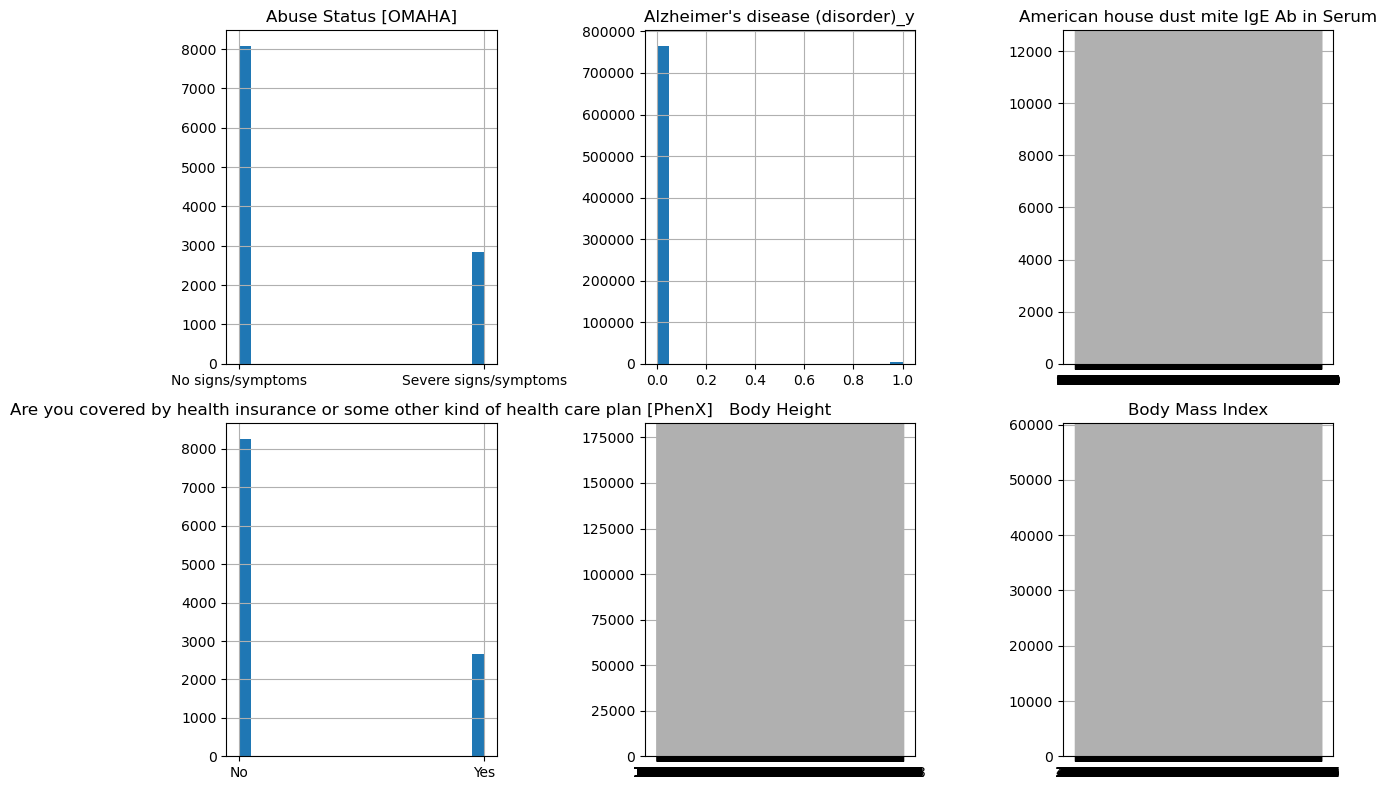

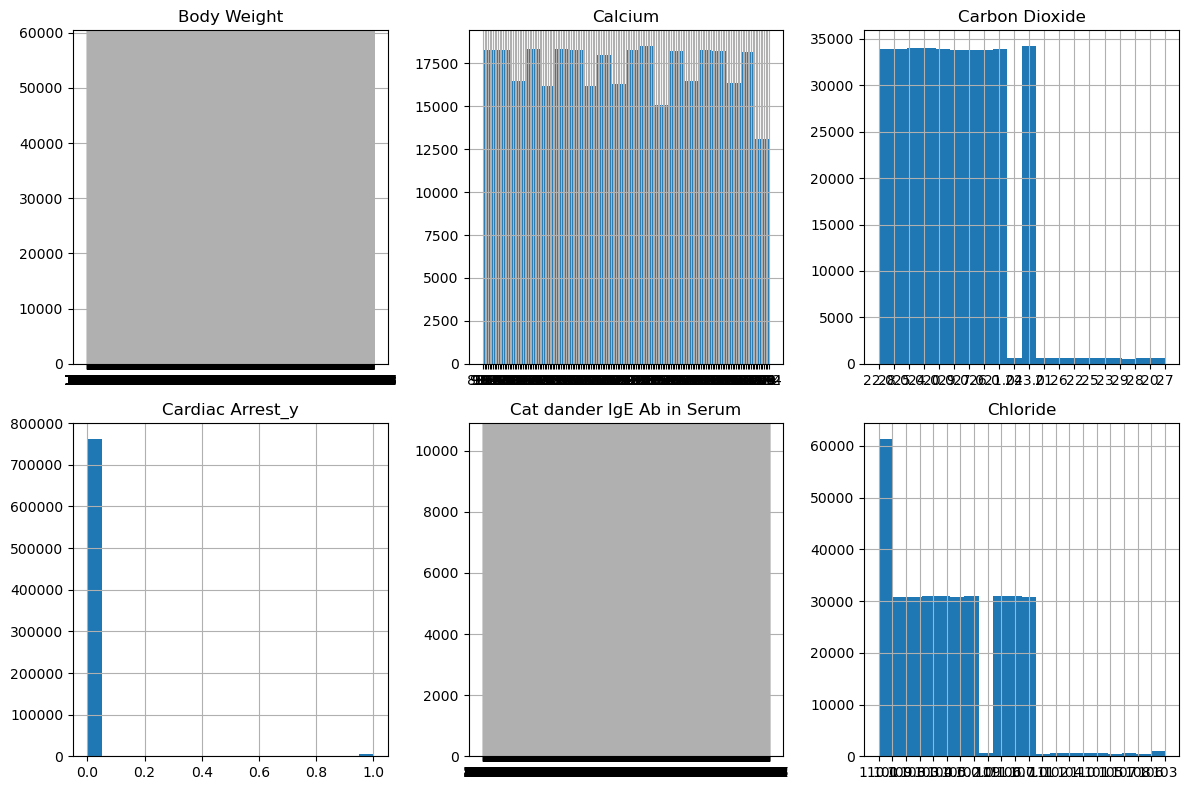

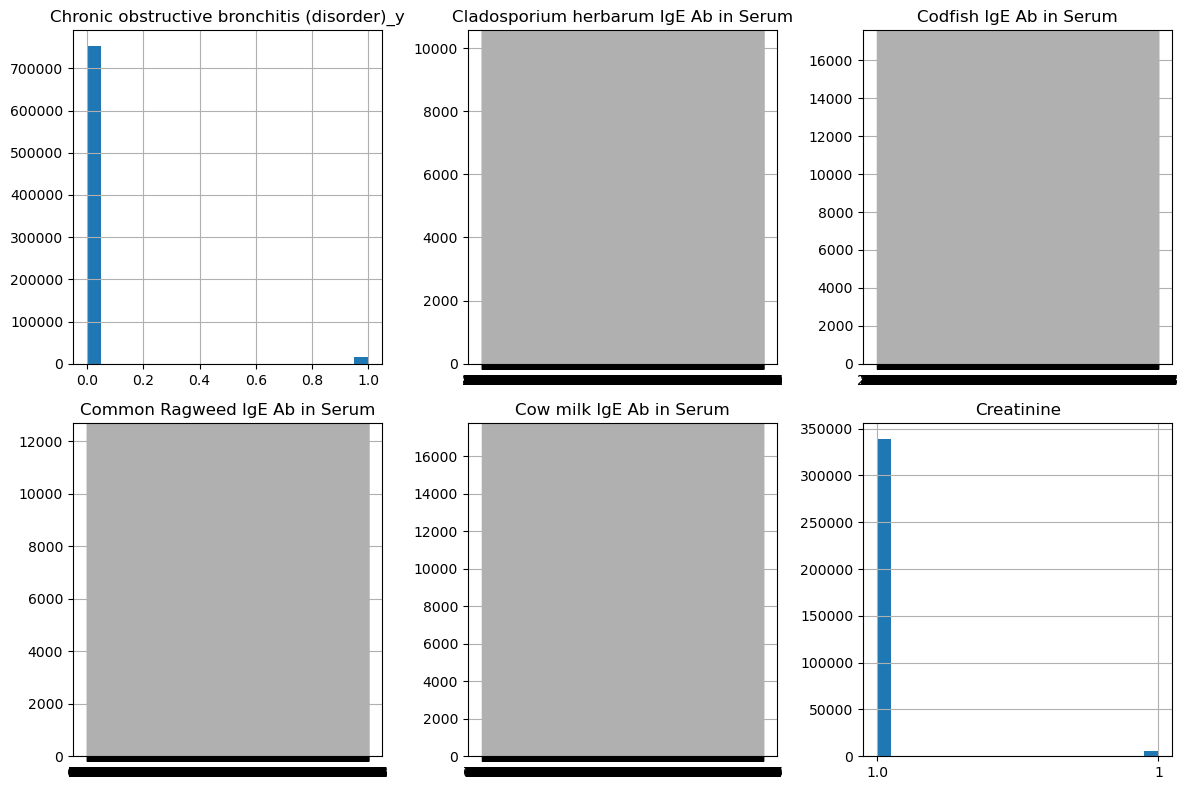

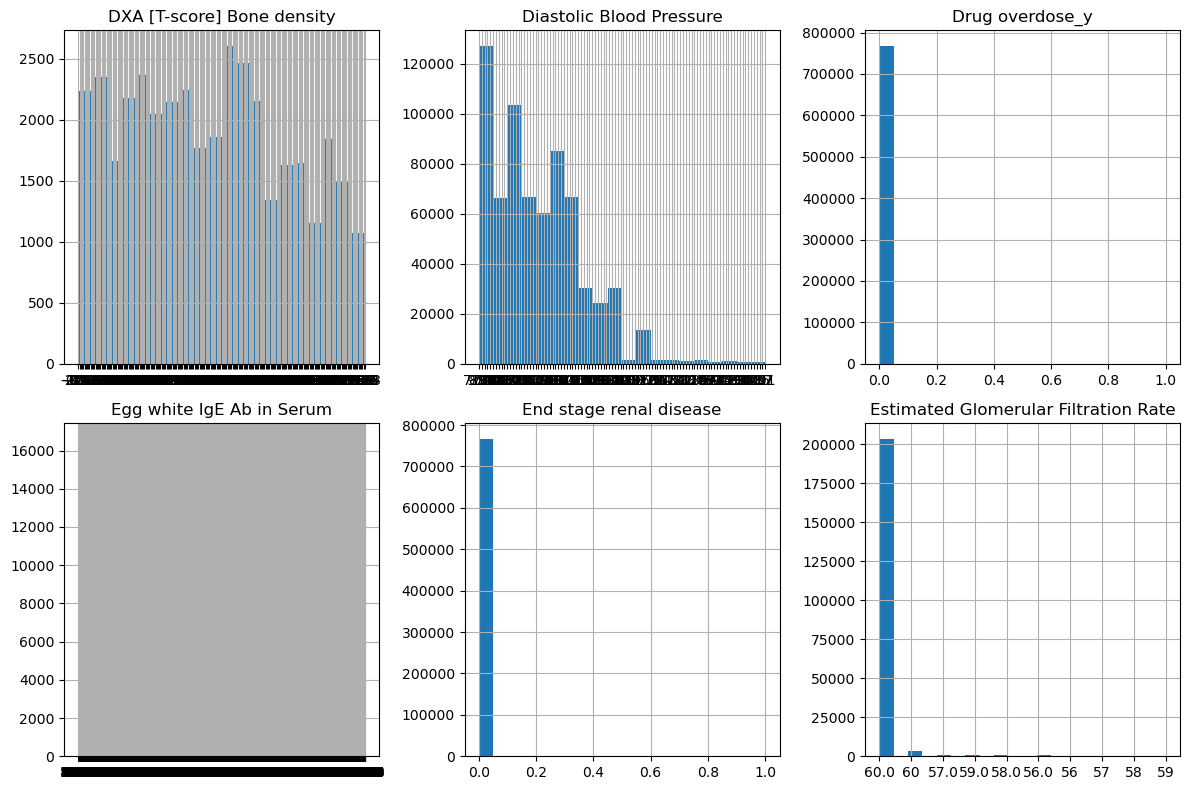

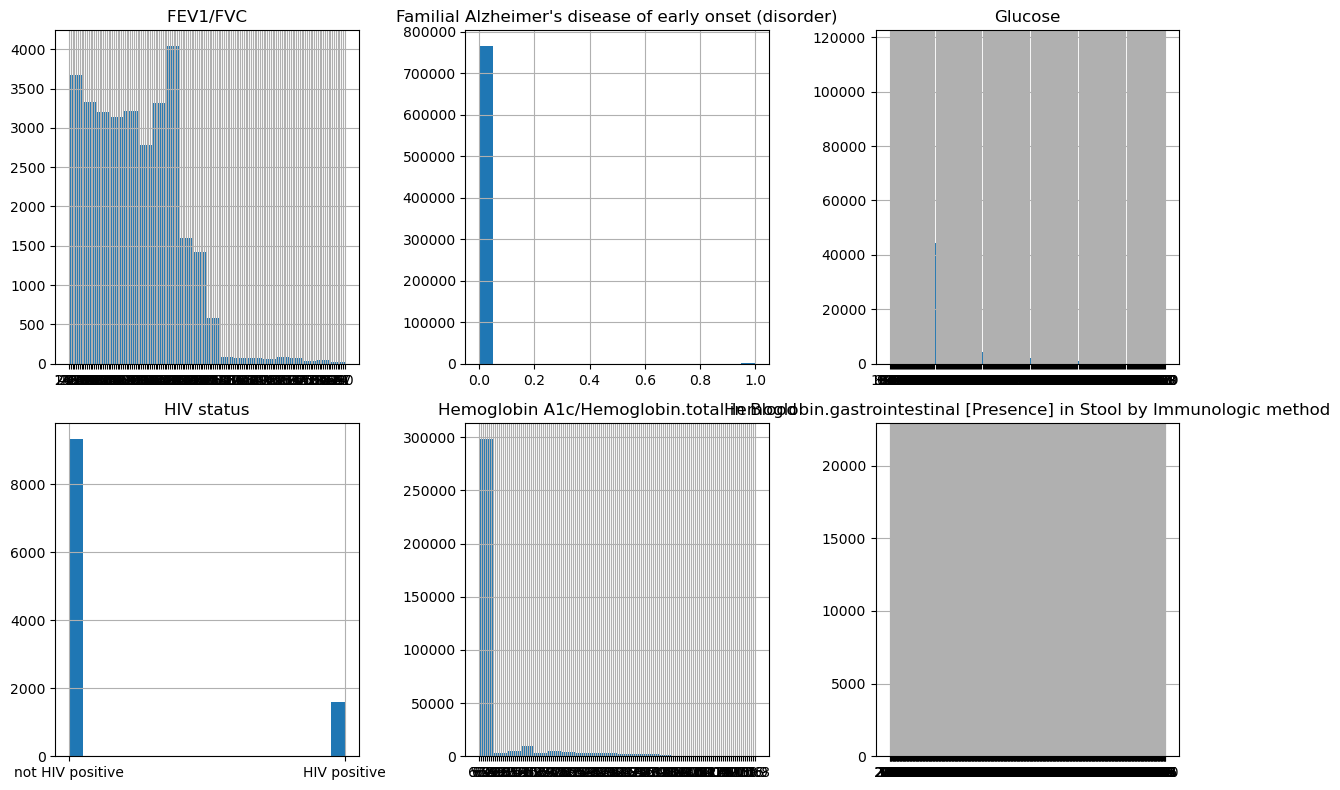

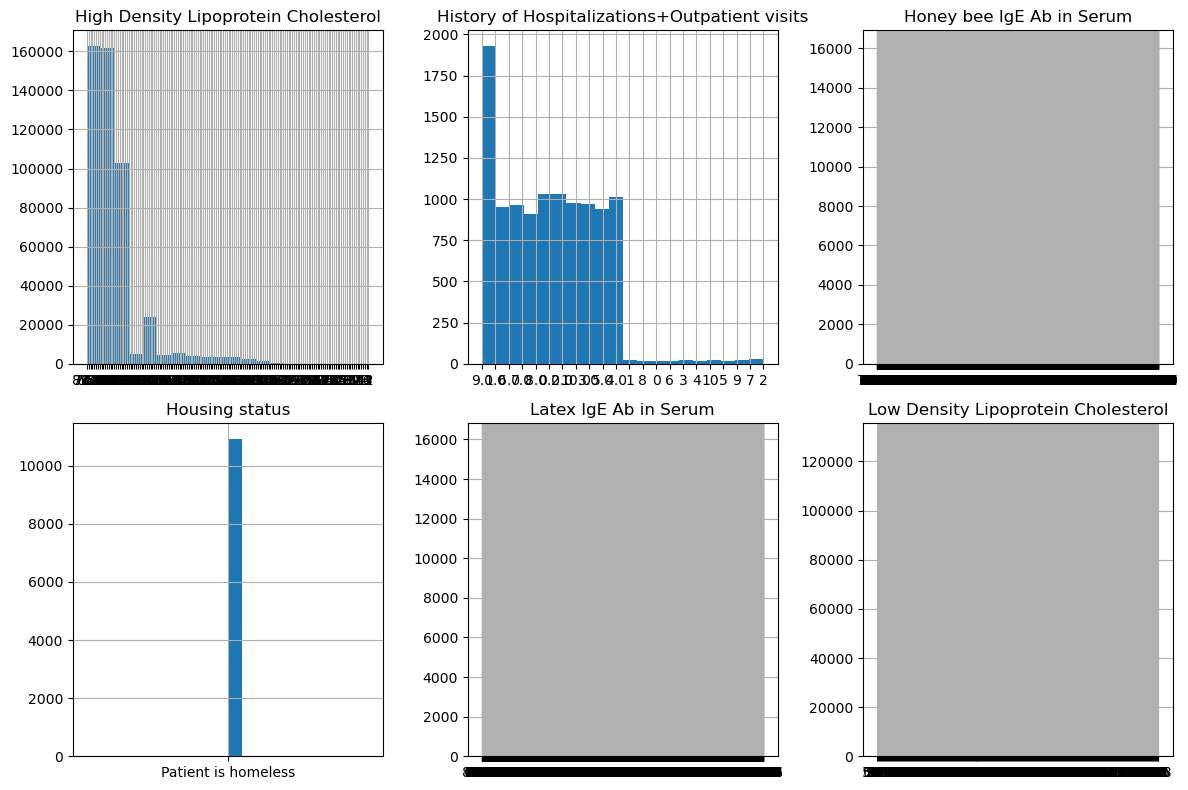

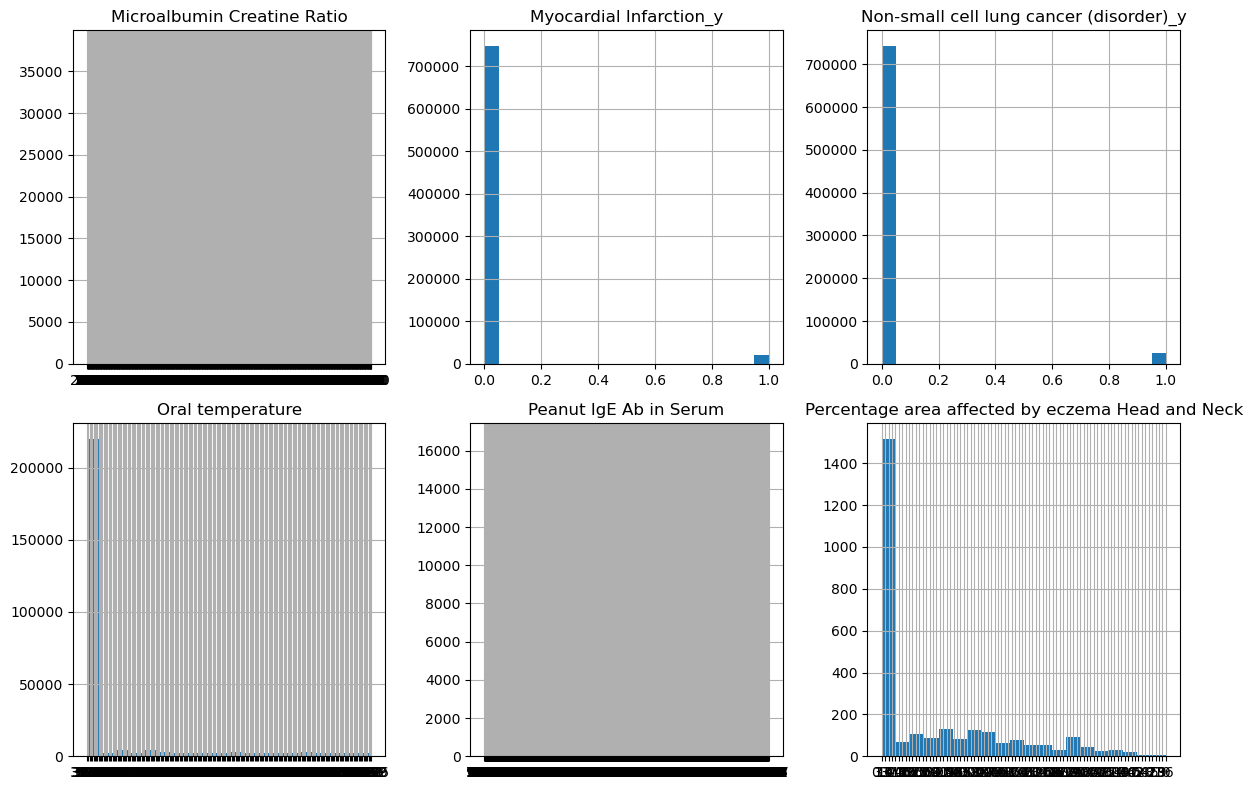

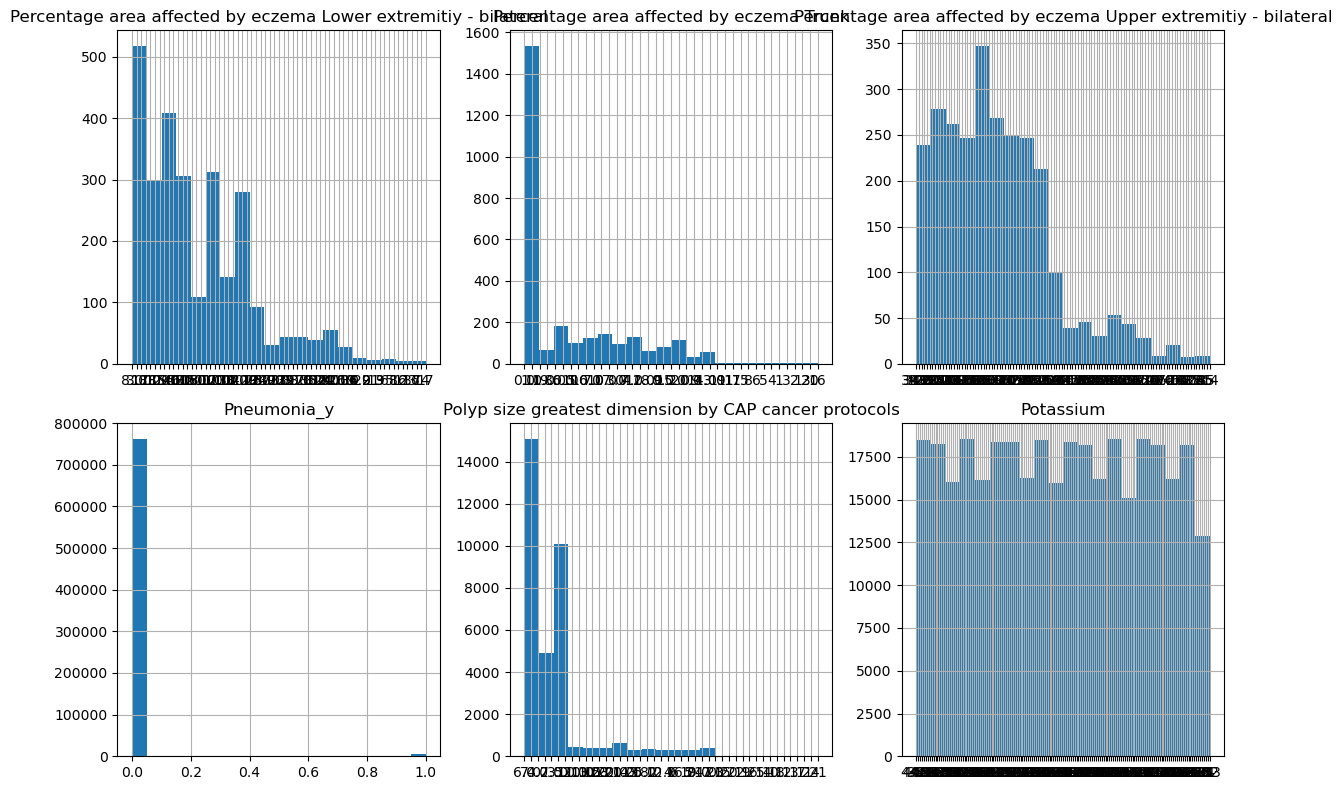

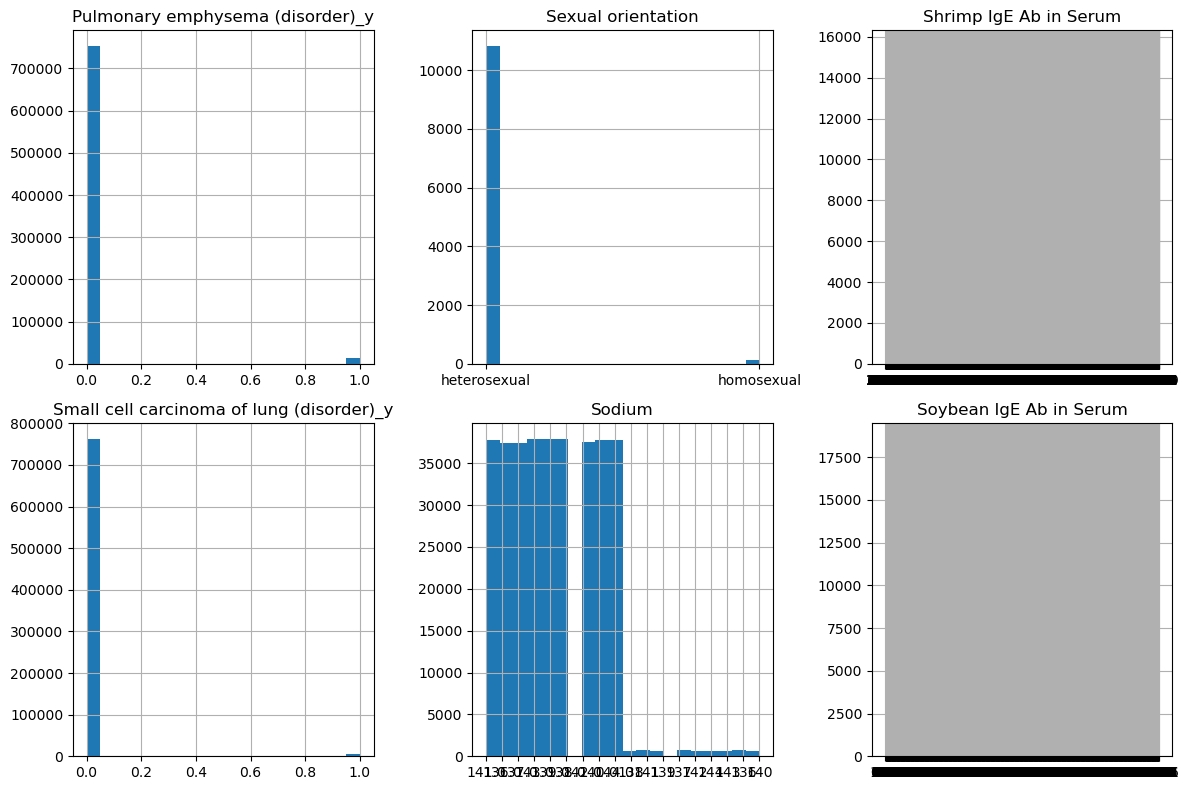

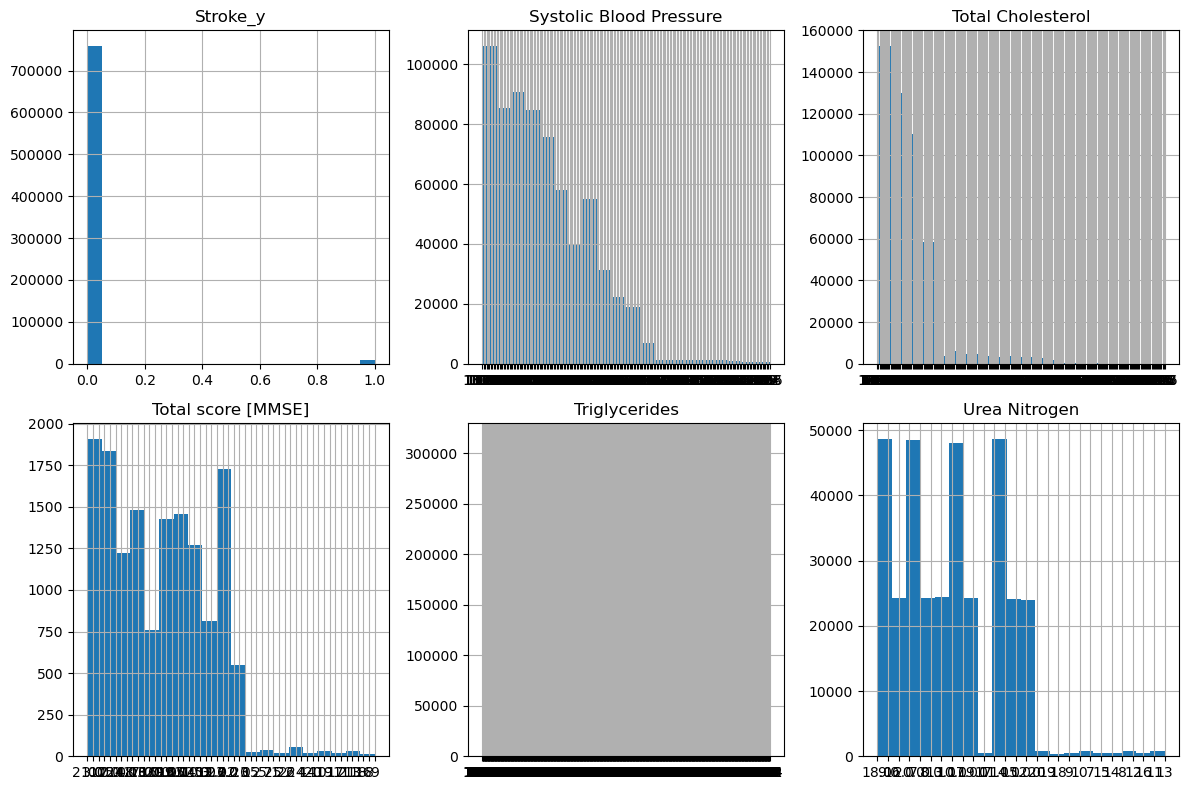

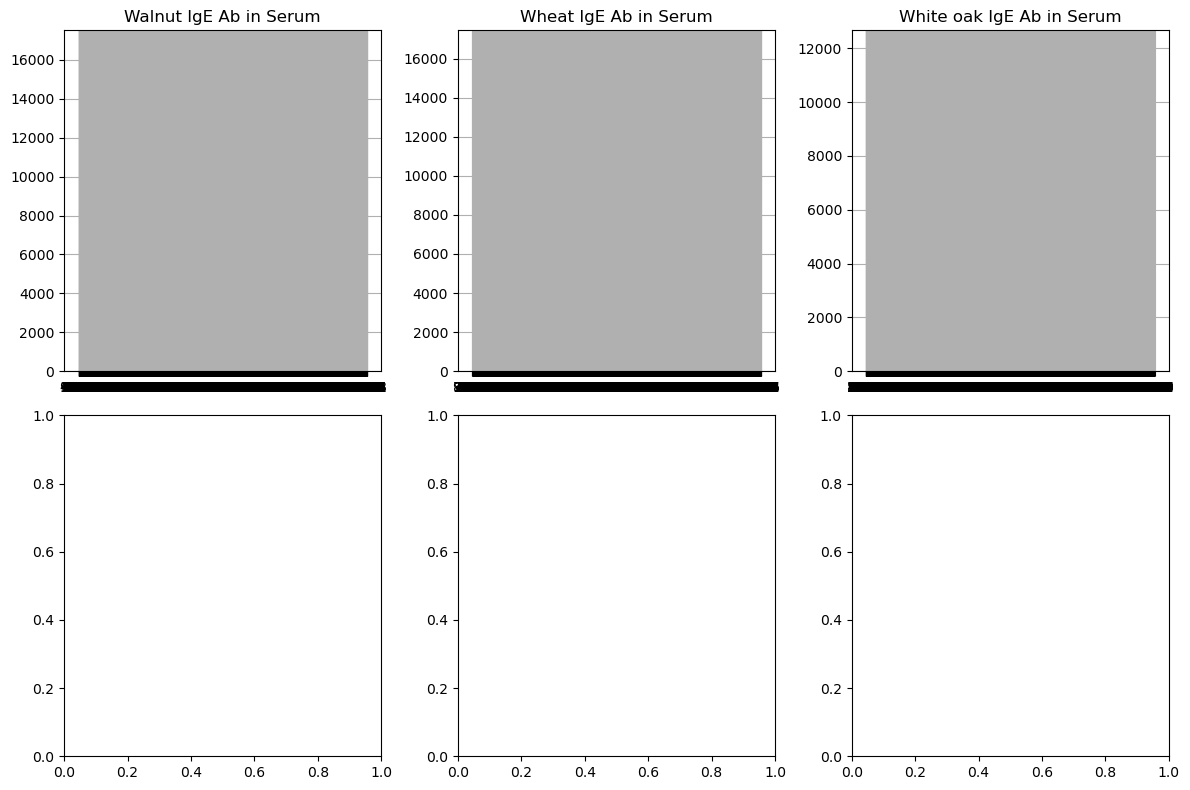

In [93]:
# Iterate over the columns and create subplots
for i in range(num_figures):
    start_idx = i * 6
    end_idx = (i + 1) * 6
    subset_columns = columns_with_null.index[start_idx:end_idx]

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
    fig.subplots_adjust(hspace=0.4)
    
    for ax, column in zip(axes.flatten(), subset_columns):
        dfPlusObservations[column].hist(bins=20, ax=ax)
        ax.set_title(column)
    
    plt.tight_layout()
    plt.show()

Dimensions of table at the outset.

In [94]:
dfPlusObservations.shape

(824306, 173)

IgE measurements are usually performed on patients with allergies. Features containing IgE measurements will be removed for downstream analysis in order to reduce the dimensions of the data and be able to perform computations in adequate timespan.  It should be noted, however that there has been an association of obesity-induced mast cell activation, inflammation and immunoglobulin E (IgE) production and prediabetes and type 1 diabetes mellitus. With more time and computational resources, these features would not be excluded for downstream analysis and null values will be set to 0 (no measurement). This does not mean that their levels are 0, but rather that they are not associated with symptoms or conditions that make a patient seek medical help.

In [107]:
columns_with_null = columns_with_null.index

IgE_columns = [name for name in columns_with_null if 'IgE' in name]
dfPlusObservations.drop (columns=IgE_columns, inplace = True)

print(dfPlusObservations.shape)

Convert `Abuse Status [OMAHA]` to 1 for symptoms and 0 for no symptoms and also 0 for NaN. Note again, that this does NOT mean that there are no symptoms/signs, but rather that the patient has not sought medical attention.

In [112]:
abuse_mapping = {'No signs/symptoms' : 0,
                 'Severe signs/symptoms' : 1,
                 pd.NA : 0,
                 np.nan : 0
                }

dfPlusObservations ['Abuse Status [OMAHA]'] = dfPlusObservations['Abuse Status [OMAHA]'].map(abuse_mapping)

Convert null values for the following features to 0 as these are congruent with absence of signs/symptoms related to the specific condition severe enough to trigger visit to the physician:
- 'Alzheimer's disease (disorder)_y'
- 'Are you covered by health insurance or some other kind of health care plan [PhenX]'
- 'Cardiac Arrest_y'
- 'Chronic obstructive bronchitis (disorder)_y'
- 'Drug overdose_y'
- 'End stage renal disease'
- 'Familial Alzheimer's disease of early onset (disorder)'
- 'HIV status'
- 'Myocardial Infarction_y'
- 'Non-small cell lung cancer (disorder)_y'
- 'Percentage area affected by eczema Head and Neck'
- 'Percentage area affected by eczema Lower extremitiy - bilateral'
- 'Percentage area affected by eczema Trunk'
- 'Percentage area affected by eczema Upper extremitiy - bilateral'
- 'Pneumonia_y'
- 'Polyp size greatest dimension by CAP cancer protocols'
- 'Pulmonary emphysema (disorder)_y'
- 'Small cell carcinoma of lung (disorder)_y'
- 'Stroke_y'

In [113]:
cols_as_0s = ["Alzheimer's disease (disorder)_y",
              'Are you covered by health insurance or some other kind of health care plan [PhenX]',
              'Cardiac Arrest_y',
              'Chronic obstructive bronchitis (disorder)_y',
              'Drug overdose_y',
              'End stage renal disease',
              "Familial Alzheimer's disease of early onset (disorder)",
              'HIV status',
              'Myocardial Infarction_y',
              'Non-small cell lung cancer (disorder)_y',
              'Percentage area affected by eczema Head and Neck',
              'Percentage area affected by eczema Lower extremitiy - bilateral',
              'Percentage area affected by eczema Trunk',
              'Percentage area affected by eczema Upper extremitiy - bilateral',
              'Pneumonia_y',
              'Polyp size greatest dimension by CAP cancer protocols',
              'Pulmonary emphysema (disorder)_y',
              'Small cell carcinoma of lung (disorder)_y',
              'Stroke_y']

dfPlusObservations[cols_as_0s] = dfPlusObservations[cols_as_0s].fillna(0)

Fill in the null values for the following features with the **median** for that category.  
Why is the median used here?  
There are multiple reasons to consult a physician so one hopes that the median would be representative of the corresponding test value for a relatively healthy individual. 
- 'Body Height'
- 'Body Mass Index'
- 'Body Weight'
- 'Calcium'
- 'High Density Lipoprotein Cholesterol'
  
For the following values, the **mode** will be selected as it is judged to be the most represetnative of a healthy individual:
- 'Oral temperature'

The following variables will be assigned specific values based on conventional readings for healthy individuals:
- 'Estimated Glomerular Filtration Rate' = 60
- 'Diastolic Blood Pressure'  = 79
- 'Chloride' = 102
- 'FEV1/FVC' = 70
- 'Glucose' = 85
- 'Low Density Lipoprotein Cholesterol' = 75
- 'Microalbumin Creatine Ratio' = 29
- 'Potassium' = 4
- 'Sodium' = 140
- 'Systolic Blood Pressure' = 119
- 'Total Cholesterol' = 190
- 'Total score [MMSE]' = 27
- 'Triglycerides' = 1.6
- 'Urea Nitrogen' = 14

For *DXA [T-score] Bone density*, 0 will be selected since this score represents the difference with normal readings.
- 'DXA [T-score] Bone density'

The following columns will be dropped from the table as they are usually associated with tests for prediabetes. This is not congruent with our task of predicting prediabetes incidence on available medical records **before** it occurs:
- 'Hemoglobin A1c/Hemoglobin.total in Blood'  
  
In addition, `housing status` will also be dropped.

In [122]:
# Define a dictionary for replacement
replacement_dict = {
    'Body Height' : dfPlusObservations['Body Height'].median(),
    'Body Mass Index' : dfPlusObservations['Body Height'].median(),
    'Body Weight' : dfPlusObservations['Body Height'].median(),
    'Calcium' : 2.4,
    'High Density Lipoprotein Cholesterol' : dfPlusObservations['High Density Lipoprotein Cholesterol'].median(),
        
    'Estimated Glomerular Filtration Rate' : 60,
    'Diastolic Blood Pressure' : 79,
    'Chloride' : 102,
    'FEV1/​FVC' : 70,
    'Glucose' : 85,
    'Low Density Lipoprotein Cholesterol' : 75,
    'Microalbumin Creatine Ratio' : 29,
    'Potassium' : 4,
    'Sodium' : 140,
    'Systolic Blood Pressure' : 119,
    'Total Cholesterol' : 190,
    'Total score [MMSE]' : 27,
    'Triglycerides' : 1.6,
    'Urea Nitrogen' : 14,
    
    'DXA [T-score] Bone density' : 0,
    
    'Oral temperature' : dfPlusObservations['Oral temperature'].mode()
}

In [123]:
list(replacement_dict.keys())

['Body Height',
 'Body Mass Index',
 'Body Weight',
 'Calcium',
 'High Density Lipoprotein Cholesterol',
 'Estimated Glomerular Filtration Rate',
 'Diastolic Blood Pressure',
 'Chloride',
 'FEV1/\u200bFVC',
 'Glucose',
 'Low Density Lipoprotein Cholesterol',
 'Microalbumin Creatine Ratio',
 'Potassium',
 'Sodium',
 'Systolic Blood Pressure',
 'Total Cholesterol',
 'Total score [MMSE]',
 'Triglycerides',
 'Urea Nitrogen',
 'DXA [T-score] Bone density',
 'Oral temperature']

In [124]:
# Replace null values with the defined values:
dfPlusObservations[list(replacement_dict.keys())] = dfPlusObservations[list(replacement_dict.keys())].fillna(replacement_dict)

# Drop 'Hemoglobin A1c/Hemoglobin.total in Blood':
dfPlusObservations.drop (columns = 'Hemoglobin A1c/Hemoglobin.total in Blood', inplace = True)

dfPlusObservations.drop (columns = 'Housing status', inplace = True)

# 'History of Hospitalizations+Outpatient visits' = 0
dfPlusObservations['History of Hospitalizations+​Outpatient visits'] = dfPlusObservations[
    'History of Hospitalizations+​Outpatient visits'
                                                                                        ].fillna(0)

# Fill Hemoglobin.gastrointestinal [Presence] in Stool with normal value for healthy individuals
dfPlusObservations['Hemoglobin.gastrointestinal [Presence] in Stool by Immunologic method'] = dfPlusObservations[
    'Hemoglobin.gastrointestinal [Presence] in Stool by Immunologic method'
].fillna(3)

We only have 2 values for sexual orientation: heterosexual and homosexual. We will assume null values are heterosexual (the largest group). Heterosexual category will be encoded as 0 and homosexual, as 1.

In [150]:
# Define the replacement mappings
replacement_dict = {'heterosexual': 0, 'homosexual': 1, pd.NA: 0, np.nan : 0}

# Convert the column using the replacement mappings
dfPlusObservations['Sexual orientation'] = dfPlusObservations['Sexual orientation'].replace(replacement_dict)

Missing valiue for carbon dioxide and oral temperature measurements will be replaced with the value for healthy subject.

In [155]:
# Replace Carbon Dioxide missing values with normal reading of 26
dfPlusObservations['Carbon Dioxide'] = dfPlusObservations ['Carbon Dioxide'].fillna(26)

# Replace null values with normal oral temperature of 37oC
dfPlusObservations['Oral temperature'] = dfPlusObservations['Oral temperature'].fillna(37.0)

`Creatinine` is a very interesting variable and all values are 1 or null. In this context, this feature will be dropped as normal levels of creatinine are about 1 and therefore the variable will not provide any additional information for the predictive model.

In [167]:
print(dfPlusObservations['Creatinine'].unique())

dfPlusObservations.drop (columns = 'Creatinine', inplace = True)

['1.0' nan '1']


Check whether any columns contain null values:

In [169]:
# Check for null values in each column
null_counts = dfPlusObservations.isnull().sum()

# Filter columns with null values
columns_with_null = null_counts[null_counts > 0]
print('Features containing null values:', columns_with_null)

Series([], dtype: int64)

Table is ready for modelling.  
Another logistic regression model with hyperparameter optimization will be performed in order to determine whether all features are contributing to explaining the the incidence of prediabetes.
  
---

## Save tidy data for modeling

In [171]:
dfPlusObservations.to_csv ('data_for_model_3.csv')

---